# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

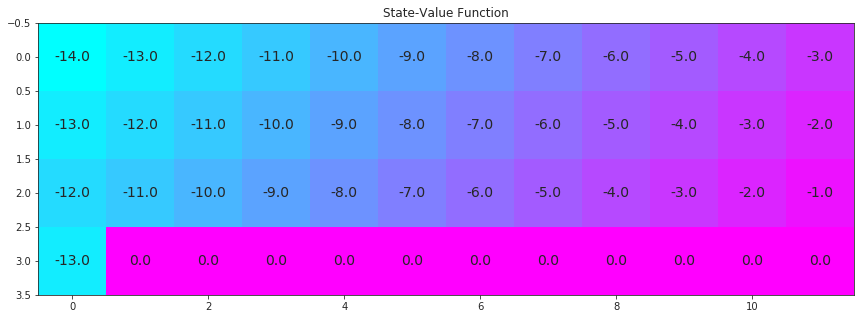

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
def update_Q(Q, sarsa_data, alpha, gamma):
    state_t, action_t, reward_t, state_tt, action_tt = sarsa_data
    if action_tt is None:
        current_return_estimate = 0
    else:
        current_return_estimate = Q[state_tt][action_tt]
        
    Q[state_t][action_t] += alpha*(reward_t + gamma*current_return_estimate - Q[state_t][action_t])
    
    return Q
    
def epsilon_greedy_policy(Q, state, epsilon, nA):
    if state in Q.keys():
        act_prob = np.repeat(epsilon/nA, nA)
        p_optimal = 1 - epsilon + epsilon/nA
        act_prob[np.argmax(Q[state])] = p_optimal
        action = np.random.choice(nA, p=act_prob)
    else:
        action = np.random.randint(nA)
       
    return action

In [6]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    nA = env.nA
    episode_return = 0
    
    # initialize performance monitor
    temp_list = []
    ave_return = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        
        if i_episode % 100 == 0:
            ave_score = np.array(temp_list).mean()
            ave_return.append(ave_score)
            temp_list = []
            print("\rEpisode {}/{}: | ave_return: {}".format(i_episode, num_episodes, ave_score), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        episode_return = 0
        state_t = env.reset()
        epsilon = max(1.0 / i_episode, 0.01)
        
        while True:
            action_t = epsilon_greedy_policy(Q, state_t, epsilon, nA)
            state_tt, reward_t, done, info = env.step(action_t)
            episode_return += reward_t
            
            if done:
                sarsa_data = (state_t, action_t, reward_t, state_tt, None)
                Q = update_Q(Q, sarsa_data, alpha, gamma)
                temp_list.append(episode_return)
                break
                
            else:
                action_tt = epsilon_greedy_policy(Q, state_tt, epsilon, nA)
                sarsa_data = (state_t, action_t, reward_t, state_tt, action_tt)
                
                Q = update_Q(Q, sarsa_data, alpha, gamma)
                
                action_t = action_tt
                state_t = state_tt
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(ave_return),endpoint=False), np.asarray(ave_return))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(ave_return))   
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000: | ave_return: -17.389494949495

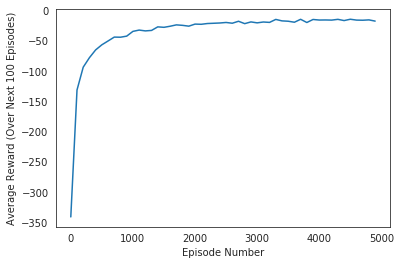

Best Average Reward over 100 Episodes:  -14.3


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  3  1  1  2  1  0  1  1  2  0]
 [ 0  2  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


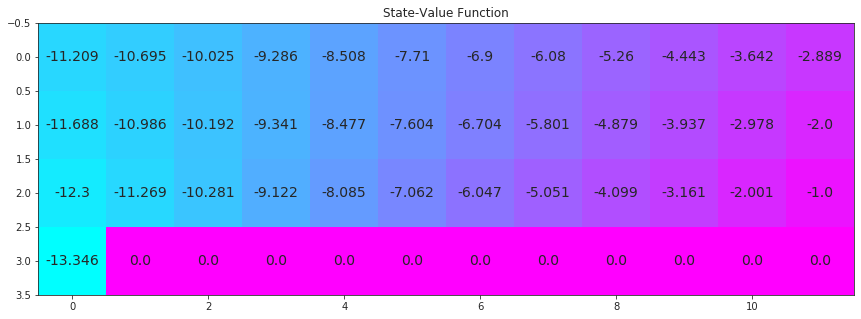

In [7]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [8]:
def update_Q_ql(Q, sars_data, alpha, gamma):
    state_t, action_t, reward_t, state_tt = sars_data
    if state_tt is None:
        current_return_estimate = 0
    else:
        current_return_estimate = Q[state_tt][np.argmax(Q[state_tt])]
        
    Q[state_t][action_t] += alpha*(reward_t + gamma*current_return_estimate - Q[state_t][action_t])
    
    return Q

In [9]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    nA = env.nA
    episode_return = 0
    
    # initialize performance monitor
    temp_list = []
    ave_return = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            ave_score = np.array(temp_list).mean()
            ave_return.append(ave_score)
            temp_list = []
            print("\rEpisode {}/{}: | ave_return: {}".format(i_episode, num_episodes, ave_score), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode_return = 0
        state_t = env.reset()
        epsilon = max(1.0 / i_episode, 0.001)
        
        while True:
            action_t = epsilon_greedy_policy(Q, state_t, epsilon, nA)
            state_tt, reward_t, done, info = env.step(action_t)
            episode_return += reward_t
            
            if done:
                sars_data = (state_t, action_t, reward_t, None)
                Q = update_Q_ql(Q, sars_data, alpha, gamma)
                temp_list.append(episode_return)
                break
                
            else:
                sars_data = (state_t, action_t, reward_t, state_tt)
                
                Q = update_Q_ql(Q, sars_data, alpha, gamma)
                state_t = state_tt
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(ave_return),endpoint=False), np.asarray(ave_return))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(ave_return))   
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000: | ave_return: -14.0871717171717

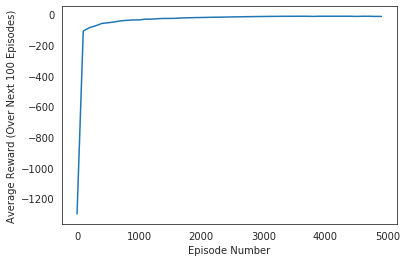

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  1  1  1  1  3  1  3  2  1  1]
 [ 0  1  1  2  3  2  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


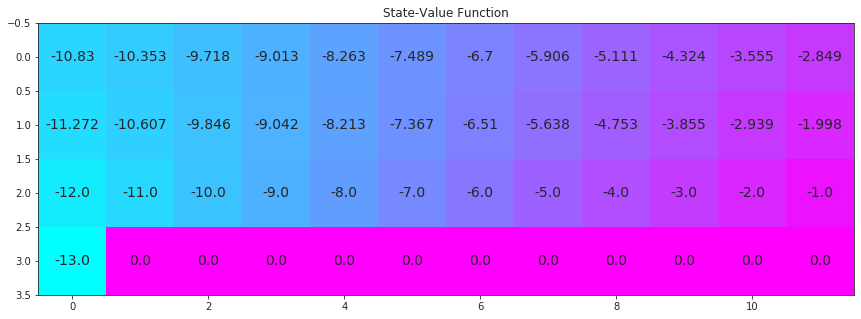

In [10]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [18]:
def action_prob_ep_greedy_policy(Q, state, epsilon, nA):
    
    if state in Q.keys():
        act_prob = np.repeat(epsilon/nA, nA)
        p_optimal = 1 - epsilon + epsilon/nA
        act_prob[np.argmax(Q[state])] = p_optimal
    else:
        act_prob = np.repeat(1/nA, nA)
        
    return act_prob

def update_Q_es(Q, sars_data, alpha, gamma, nA, action_tt_prob):
    state_t, action_t, reward_t, state_tt = sars_data

    if state_tt is None:
        current_return_estimate = 0
    else:
        current_return_estimate = np.dot(Q[state_tt], action_tt_prob)
        
    Q[state_t][action_t] += alpha*(reward_t + gamma*current_return_estimate - Q[state_t][action_t])
    
    return Q

In [19]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    nA = env.nA
    episode_return = 0
    epsilon = 1
    
    # initialize performance monitor
    temp_list = []
    ave_return = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            ave_score = np.array(temp_list).mean()
            ave_return.append(ave_score)
            temp_list = []
            print("\rEpisode {}/{}: | ave_return: {}".format(i_episode, num_episodes, ave_score), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode_return = 0
        state_t = env.reset()
        epsilon = 0.005 # max(0.999*epsilon, 0.001)
        
        while True:
            act_prob = action_prob_ep_greedy_policy(Q, state_t, epsilon, nA)
            action_t = np.random.choice(nA, p=act_prob)
            
            state_tt, reward_t, done, info = env.step(action_t)
            episode_return += reward_t
            
            if done:
                sars_data = (state_t, action_t, reward_t, None)
                Q = update_Q_es(Q, sars_data, alpha, gamma, nA, None)
                temp_list.append(episode_return)
                break
                
            else:
                sars_data = (state_t, action_t, reward_t, state_tt)
                act_prob = action_prob_ep_greedy_policy(Q, state_tt, epsilon, nA)
                Q = update_Q_es(Q, sars_data, alpha, gamma, nA, act_prob)
                state_t = state_tt
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(ave_return),endpoint=False), np.asarray(ave_return))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(ave_return))   
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000: | ave_return: -14.1630303030305

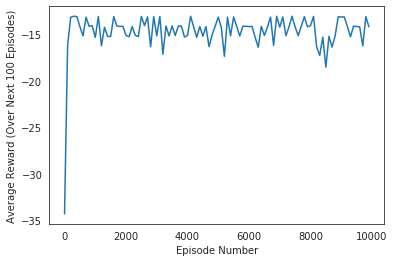

Best Average Reward over 100 Episodes:  -13.02


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  1  3  1  1  3  1  1  2  3]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


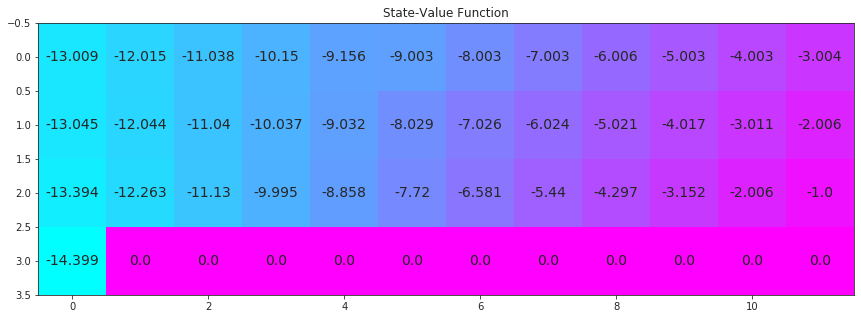

In [20]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])